## This notebook should show the performance of the models performing the best in GridSearch.

In [6]:
from drowsiness_detection import config

config.set_paths(30, 10)
import numpy as np
from drowsiness_detection.visualize import (plot_roc_over_sessions, plot_roc_over_subjects,
    plot_roc_over_n_folds)
from matplotlib import rcParams
from sklearn_evaluation import table
from drowsiness_detection.run_grid_search_experiment import base
from pprint import pprint
from sklearn.metrics import RocCurveDisplay
from sklearnex import patch_sklearn

patch_sklearn()
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
# now you can import normally from model_selection
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from drowsiness_detection import config
from sklearn.model_selection import StratifiedKFold
import json
from drowsiness_detection.data import (session_type_mapping, get_feature_data,
    preprocess_feature_data, get_session_idx)

rcParams["figure.figsize"] = 10, 10


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
config.set_paths(30, 10)

base_config = base()
# pprint(base_config)

In [8]:
def load_pickle_object(filepath: Path):
    with open(filepath, "rb") as fp:
        return pickle.load(fp)

def load_json_object(filepath: Path):
    with open(filepath, "r") as fp:
        return json.load(fp)

results_path = config.SOURCES_ROOT_PATH.parent.joinpath("logs")
ten_sec_model_path = results_path.joinpath("1/best_model.pkl")
twenty_sec_model_path = results_path.joinpath("2/best_model.pkl")
sixty_sec_model_path = results_path.joinpath("3/best_model.pkl")

model_paths = [ten_sec_model_path, twenty_sec_model_path, sixty_sec_model_path]
info_paths = [ten_sec_model_path.parent.joinpath("info.json"), twenty_sec_model_path.parent.joinpath("info.json"), sixty_sec_model_path.parent.joinpath("info.json")]

infos = [load_json_object(file) for file in info_paths]

In [9]:
exclude_by = base_config.get("exclude_by")
seed = base_config.get("seed")
n_splits = base_config.get("n_splits")
shuffle = base_config.get("shuffle", True)



In [10]:
def load_train_test_splits(frequency, seconds):
    config.set_paths(frequency, seconds)
    data = get_feature_data(data_path=config.PATHS.WINDOW_FEATURES)
    X, y = preprocess_feature_data(feature_data=data, exclude_sess_type=session_type_mapping[
        base_config["exclude_by"]], include_sess_and_subject_id=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=base_config["test_size"],
                                                        random_state=base_config["seed"])
    # return X_train, X_test, y_train, y_test
    ids_train = y_train[:,1:]
    ids_test = y_test[:, 1:]
    y_train = y_train[:, 0]
    y_test = y_test[:, 0]
    # [print(x.shape) for x in [X_train[:10], X_test[:10], y_train[:10], y_test[:10], ids_train[:10], ids_test[:10]]]
    num_samples = 5_000
    return X_train[:num_samples], X_test[:num_samples], y_train[:num_samples], y_test[:num_samples], ids_train[:num_samples], ids_test[:num_samples]


def dataset_generator():
    for seconds, model_path in zip([10, 20, 60], model_paths):
        model = load_pickle_object(model_path)
        yield (load_train_test_splits(30, seconds)), model
        break

### Show training and test metrics

In [25]:
import pandas as pd
names = ["10 sec", "20 sec", "60 sec"]
pd.set_option('display.max_columns', None)

df = pd.DataFrame(infos, index=names)
from IPython.display import HTML

HTML(df.to_html())

,best_params,cv_test_accuracy,test_accuracy,train_accuracy
10 sec,"{'classifier__criterion': 'entropy', 'classifier__max_depth': 16, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 2187}",0.737858,0.733409,0.961508
20 sec,"{'classifier__criterion': 'entropy', 'classifier__max_depth': 54, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 2187}",0.809627,0.812835,0.999928
60 sec,"{'classifier__criterion': 'entropy', 'classifier__max_depth': 32, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 2187}",0.959740,0.963597,0.992416


### Plot ROC curve of each model on test set

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 1001 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 1446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 1973 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done 2187 out of 2187 | elapsed:    1.4s finished


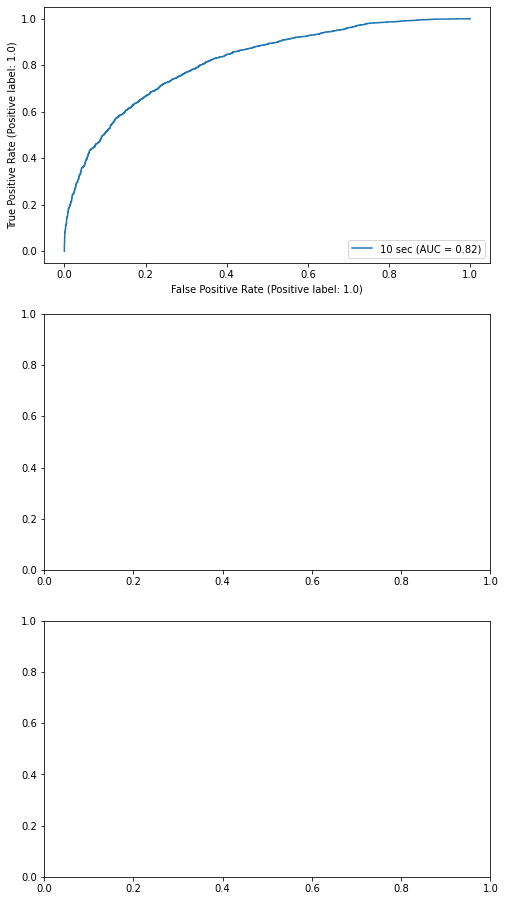

In [39]:
data_gen = dataset_generator()
rcParams["figure.figsize"] = 8,16
i  = 1
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
names = ["10 sec", "20 sec", "60 sec"]
for (X_train, X_test, y_train, y_test, _, _), model in data_gen:
    name, *names = names
    RocCurveDisplay.from_estimator(model, X=X_test, y=y_test, ax=ax1, name=name)
plt.show()


#### Plot ROC of each model with the ROC Curve on the data for each session separately.
- on test data

(5000, 785) (5000,)


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 1001 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 1446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 1973 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 2187 out of 2187 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 1001 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 1446 

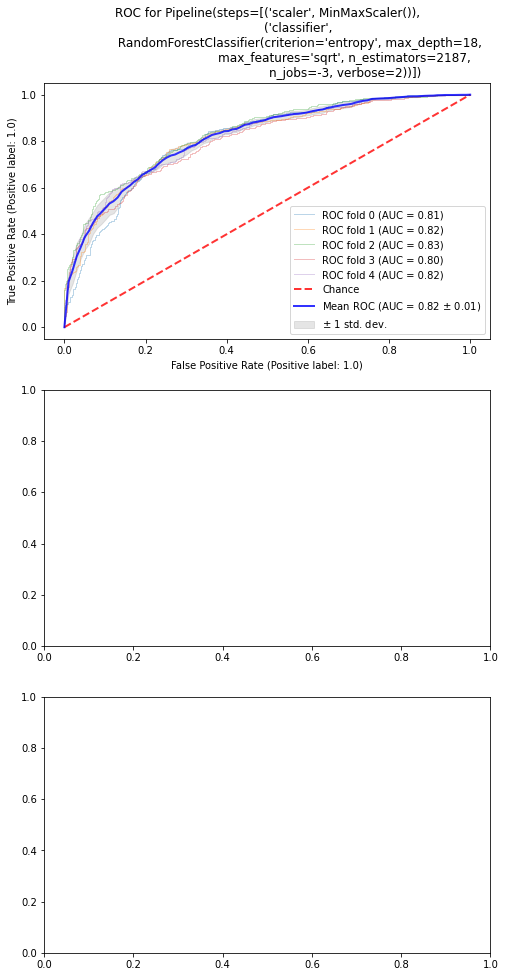

In [36]:
data_gen = dataset_generator()
rcParams["figure.figsize"] = 8,16
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
names = ["10 sec", "20 sec", "60 sec"]
axes = list((ax1, ax2, ax3))
n_splits = 5
for (X_train, X_test, y_train, y_test, _, _), model in data_gen:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    plot_roc_over_n_folds(classifier=model, X=X_test, y=y_test, cv=cv, ax=axes.pop(0))
    plt.show()

(10, 785)
(10, 785)
(10,)
(10,)
(10, 2)
(10, 2)


Error evaluating: thread_id: pid_126445_id_139978117992896
frame_id: 1923961312
scope: FRAME
attrs: indices
Traceback (most recent call last):
  File "/opt/pycharm-2021.2.2/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_vars.py", line 286, in resolve_compound_variable_fields
    return _typeName, resolver.get_dictionary(VariableWithOffset(var, offset) if offset else var)
  File "/opt/pycharm-2021.2.2/plugins/python/helpers/pydev/pydevd_plugins/extensions/types/pydevd_plugin_numpy_types.py", line 93, in get_dictionary
    ret['min'] = obj.min()
  File "/home/tim/IM/venv/lib/python3.9/site-packages/numpy/core/_methods.py", line 44, in _amin
    return umr_minimum(a, axis, None, out, keepdims, initial, where)
ValueError: zero-size array to reduction operation minimum which has no identity


KeyboardInterrupt: 

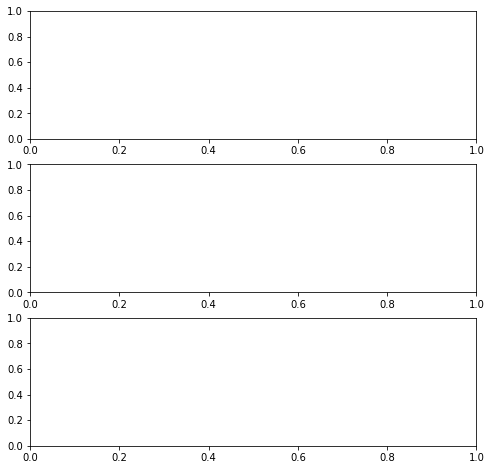

In [ ]:
"""data_gen = dataset_generator()
rcParams["figure.figsize"] = 8,8
i  = 1
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
names = ["10 sec", "20 sec", "60 sec"]
axes = list((ax1, ax2, ax3))
for (X_train, X_test, y_train, y_test, ids_train, ids_test), model in data_gen:
    ids = get_session_idx(ids=ids_test[:,-2])
    plot_roc_over_sessions(classifier=model, identifiers=ids, X=X_test, y=y_test, ax=axes.pop())
    plt.show()"""

#### Plot ROC of each model with the ROC Curve for each subject separately.
- on test data


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1001 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 1973 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 2187 out of 2187 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1001 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1446 

ValueError: Found array with 0 sample(s) (shape=(0, 785)) while a minimum of 1 is required.

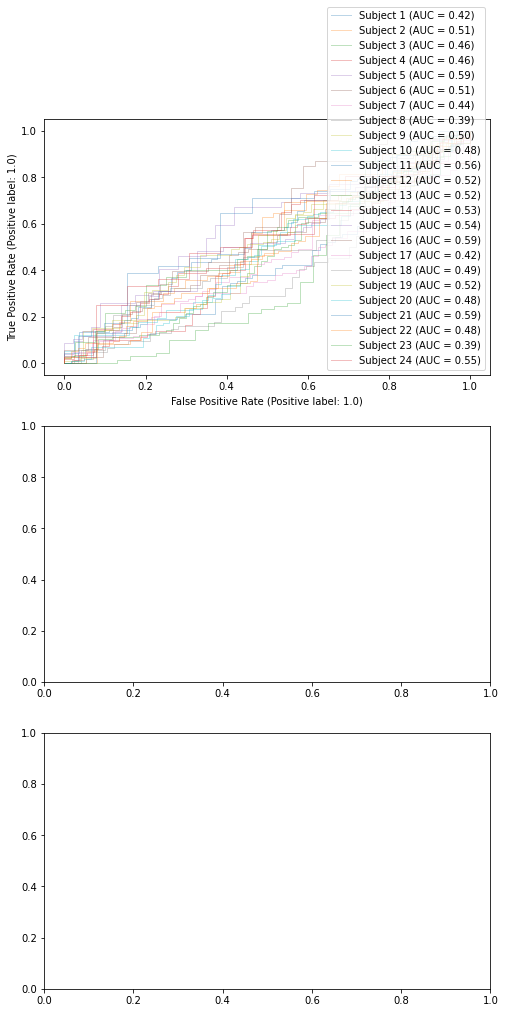

In [11]:
data_gen = dataset_generator()
rcParams["figure.figsize"] = 8,16
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
names = ["10 sec", "20 sec", "60 sec"]
axes = [ax1, ax2, ax3]
for (X_train, X_test, y_train, y_test, ids_train, ids_test), model in data_gen:
    plot_roc_over_subjects(classifier=model, identifiers=ids_test, X=X_test, y=y_train, ax=axes.pop(0))

In [ ]:
table.feature_importances(data=random_forest.feature_importances_, top_n=30,
                          feature_names=FEATURE_NAMES)

In [ ]:
table.feature_importances(data=log_regression.coef_[0], feature_names=FEATURE_NAMES)

In [ ]:
log_regression.coef_.shape